In [171]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
import joblib

In [172]:
# 1. Load Dataset
df = pd.read_csv('keypoints.csv')

# 2. Normalize Keypoints Safely
def normalize_keypoints(row):
    row = np.array(row, dtype=np.float32)
    if np.isnan(row).any() or np.isinf(row).any():
        return np.zeros_like(row)
    try:
        row = row.reshape(-1, 3)  # assume (n_landmarks * 3)
        x = row[:, 0]
        y = row[:, 1]

        x -= x[0]
        y -= y[0]

        max_range = max(np.ptp(x), np.ptp(y))
        if max_range == 0:
            max_range = 1e-5

        x /= max_range
        y /= max_range

        row[:, 0] = x
        row[:, 1] = y
        return row.flatten()

    except Exception as e:
        print("Bad row, skipping:", e)
        return np.zeros_like(row)
    

X = df.drop('label', axis=1).values
X_normalized = np.array([normalize_keypoints(row) for row in X])


In [173]:
# Remove NaNs/Infs and all-zero rows
mask = ~np.isnan(X_normalized).any(axis=1) & ~np.isinf(X_normalized).any(axis=1) & ~np.all(X_normalized == 0, axis=1)
X_cleaned = X_normalized[mask]
y_cleaned = df['label'].values[mask]


# 4. Encode labels
y_encoded = LabelEncoder().fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Save label encoder for real-time prediction
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_int)
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [189]:
# Check the shapes before any modifications
print(f"X_cleaned shape: {X_cleaned.shape}")
print(f"y_categorical shape: {y_categorical.shape}")

# Remove rows with missing values in either X_cleaned or y_categorical
# This ensures that both X_cleaned and y_categorical have the same length
df_cleaned = pd.concat([pd.DataFrame(X_cleaned), pd.Series(y_categorical)], axis=1).dropna()

# Separate the features and target after cleaning
X_cleaned = df_cleaned.drop(df_cleaned.columns[-1], axis=1).values
y_categorical = df_cleaned.iloc[:, -1].values

# Check the shapes after cleaning
print(f"X_cleaned shape after cleaning: {X_cleaned.shape}")
print(f"y_categorical shape after cleaning: {y_categorical.shape}")

# Now, split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y_categorical, test_size=0.2, random_state=42
)

# Check the shapes of the resulting splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_cleaned shape: (1093, 149)
y_categorical shape: (1093,)
X_cleaned shape after cleaning: (1093, 148)
y_categorical shape after cleaning: (1093,)
X_train shape: (874, 148)
X_test shape: (219, 148)
y_train shape: (874,)
y_test shape: (219,)


In [190]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)
class_weights = dict(enumerate(class_weights))


In [191]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout

# Calculate number of classes
num_classes = len(np.unique(y_categorical))

# Build the model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # Use num_classes instead of y_categorical.shape[1]
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [186]:
# Step 1: Check the unique labels in y_train and y_test
print(f"Unique labels in y_train: {np.unique(y_train)}")
print(f"Unique labels in y_test: {np.unique(y_test)}")

# Step 2: Create a continuous label mapping
unique_labels = np.unique(np.concatenate([y_train, y_test]))  # Combine both sets
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

# Step 3: Map the labels to continuous range
y_train_mapped = np.array([label_mapping[label] for label in y_train])
y_test_mapped = np.array([label_mapping[label] for label in y_test])

from tensorflow.keras.utils import to_categorical

# Step 4: Convert y_train and y_test to one-hot encoded labels
num_classes = len(unique_labels)  # Get the number of classes from the unique labels
y_train_one_hot = to_categorical(y_train_mapped, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test_mapped, num_classes=num_classes)


Unique labels in y_train: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 16 18 19 20 22 24 25 26 28 29
 30 32 33 34 36 38 39 40 41 42]
Unique labels in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 16 18 20 22 24 25 26 28 29 30
 32 33 34 36 38 39 40 41 42]


In [192]:
from tensorflow.keras.callbacks import EarlyStopping

# Step 5: Set up EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 6: Train the model
history = model.fit(
    X_train, y_train_one_hot,  # Use the one-hot encoded labels
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight=class_weights  # Make sure class_weights is defined
)

# Step 7: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_one_hot)  # Use the one-hot encoded test labels
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/50


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 43), output.shape=(None, 34)

In [187]:
from tensorflow.keras.callbacks import EarlyStopping

# 8. Train with EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train_one_hot,  # Use y_train_one_hot here
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight=class_weights  # Add class weights if necessary
)

# 9. Evaluate
loss, accuracy = model.evaluate(X_test, y_test_one_hot)  # Use y_test_one_hot here
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/50


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 43), output.shape=(None, 34)

In [ ]:
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

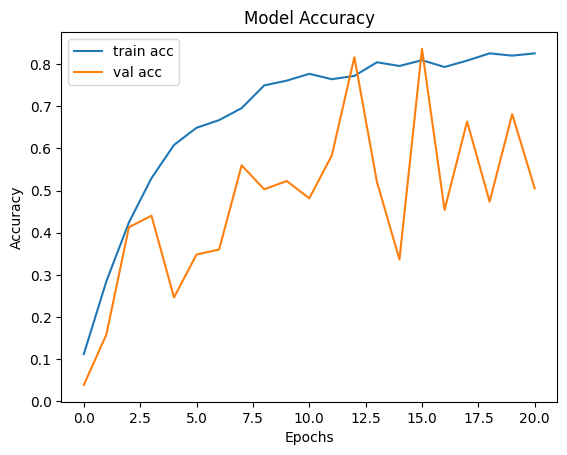

In [ ]:
# 10. Optional: Plot accuracy/loss curves
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()